# IGP 5 Models

## Preprocessing

1. import files into dataframe
2. extract 'full' days (1440 rows per date)
3. extract number of days matching scores.csv

In [1]:
# load functions in python file with magic command
%run ../code/preprocess.py

In [2]:
import pandas as pd
folderpath = '../depresjon'
output_csv_path = '../output/'
scores_csv_path = '../depresjon/scores.csv'

# extract files
df = extract_from_folder(folderpath)

# extract full days (true days)
full_df = preprocess_full_days(df)

# extract days per scores 
final = extract_days_per_scores(full_df, scores_csv_path)

# pivot df to wide format
final_pivot = pivot_dataframe(final)

In [3]:
# save to csv
final_pivot.to_csv(output_csv_path + 'preprocessed-wide.csv', index=False)
final.to_csv(output_csv_path+ 'preprocessed-long.csv', index=False)

In [4]:
# list of variable names to delete
var_list = ['df', 'full_df',  'final', 'final_pivot']

# loop over the list and delete variables if they exist
for var in var_list:
    if var in locals():
        del locals()[var]


### Notes

* Kept all id, date combinations to maximise data
* will split into train, test, val
* will keep proportions



## Import from CSV

1. import preprocessed csv file

In [1]:
import pandas as pd
output_csv_path = '../output/'
scores_csv_path = '../depresjon/scores.csv'

# import from csv
df = pd.read_csv(output_csv_path + 'preprocessed-long.csv', parse_dates=['timestamp', 'date'])

## Features

>all row level, therfore no data leakage - that is features are computed separately for each (id, date) combination so that there is no data leakage / contamination


* **inactiveDay**: The proportion of time during the day when the participant is inactive.

$\text{{inactiveDay}} = \frac{{\text{{Number of inactive hours during the day}}}}{{\text{{Total number of hours during the day}}}}$


* **activeNight**: The proportion of time during the night when the participant is active.

$\text{{activeNight}} = \frac{{\text{{Number of active hours during the night}}}}{{\text{{Total number of hours during the night}}}}$

* **inactiveLight**: The proportion of time during periods of light (e.g., daytime) when the participant is inactive.

$\text{{inactiveLight}} = \frac{{\text{{Number of inactive hours during periods of light}}}}{{\text{{Total number of hours during periods of light}}}}
$


* **activeDark**: The proportion of time during periods of darkness (e.g., nighttime) when the participant is active.

$\text{{activeDark}} = \frac{{\text{{Number of active hours during periods of darkness}}}}{{\text{{Total number of hours during periods of darkness}}}}$


* **mean**: The average value of activity data for each hour of the day. It represents the central tendency of the data.

$\text{{mean}}_{\text{{person-date}}} = \frac{{\sum_{i=1}^{n} \text{{activity}}_{\text{{person-date}}}(i)}}{{n}}$


* **std**: The standard deviation of activity data for each hour of the day. It measures the dispersion or spread of the data around the mean.

$\text{{std}}_{\text{{person-date}}} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (\text{{activity}}_{\text{{person-date}}}(i) - \text{{mean}}_{\text{{person-date}}})^2}$


* **percentZero**: The percentage of data points that have a value of zero for each hour of the day.

$\text{{percent\_zero}}_{\text{{person-date}}} = \frac{{\text{{Number of hours with zero activity}}_{\text{{person-date}}}}}{{\text{{Total number of hours}}_{\text{{person-date}}}}} \times 100$


* **kurtosis**: A measure of the "tailedness" or shape of a distribution. It indicates how sharply peaked or flat the distribution is compared to a normal distribution. Positive kurtosis indicates a relatively peaked distribution, while negative kurtosis indicates a relatively flat distribution.

$\text{{kurtosis}}_{\text{{person-date}}} = \frac{{\frac{1}{n} \sum_{i=1}^{n} (\text{{activity}}_{\text{{person-date}}}(i) - \text{{mean}}_{\text{{person-date}}})^4}}{{\left( \frac{1}{n} \sum_{i=1}^{n} (\text{{activity}}_{\text{{person-date}}}(i) - \text{{mean}}_{\text{{person-date}}})^2 \right)^2}}$



To calculate the above features: 

* **Day / Night** - determined by hours, e.g. 08:00-20:00

$\text{{day\_night}} = \begin{cases} 
0 & \text{{if }} \text{{day\_start}} \leq \text{{hour}} < \text{{day\_end}} \\
1 & \text{{otherwise}}
\end{cases}$

* **Light / Dark** - determined by monthly sunset/sunrise times in Norway

$\text{{light\_dark}} = \begin{cases} 
0 & \text{{if }} \text{{sunrise\_time}} \leq \text{{timestamp}} < \text{{sunset\_time}} \\
1 & \text{{otherwise}}
\end{cases}$


* **Active / Inactive** - active is where the rolling average (window = 11) of 'active minute' (threshold > 5) is greater than 2

$\text{{active\_inactive}} = \begin{cases} 
1 & \text{{if }} \text{{activity}} \geq \text{{activity\_threshold}} \\
0 & \text{{otherwise}}
\end{cases}$

$\text{{rolling\_sum}} = \text{{rolling sum of }} \text{{active\_inactive}} \text{{ over a window of }} \text{{rolling\_window}}$

$\text{{active\_inactive\_period}} = \begin{cases} 
1 & \text{{if }} \text{{rolling\_sum}} \geq \text{{rolling\_threshold}} \\
0 & \text{{otherwise}}
\end{cases}$





In [2]:
# load functions in python file with magic command
%run ../code/features.py

In [3]:
# calculate features
features_full = calculate_all_features(df, sunlight_df)

In [ ]:
features_full

## Split into Female, Male, Both datasets

In [4]:
# load functions in python file with magic command
%run ../code/model.py


ModuleNotFoundError: No module named 'lightgbm'

In [5]:

male, female, both = split_and_prepare_data(features_full)

# shapes of the datasets 
print(f"Male dataset shape: {male.shape}")
print(f"Female dataset shape: {female.shape}")
print(f"Both genders dataset shape: {both.shape}")


Male dataset shape: (310, 9)
Female dataset shape: (383, 9)
Both genders dataset shape: (693, 9)


In [6]:
print(male.head())

   label  inactiveDay  activeNight  inactiveLight  activeDark        mean  \
0      1     0.144444     0.300000       0.300193    0.264851  156.247222   
1      1     0.301389     0.354167       0.395753    0.326733  124.135417   
2      1     0.125000     0.341667       0.301158    0.376238  134.961806   
3      1     0.144444     0.269444       0.291506    0.188119   99.439583   
4      1     0.111111     0.301389       0.271236    0.252475  316.874306   

          std  percent_zero   kurtosis  
0  229.109777     40.902778   8.792571  
1  211.241278     46.180556  10.550960  
2  230.954732     37.430556  15.449014  
3  177.719972     42.013889  21.223210  
4  496.184847     39.375000   7.679689  


## Model

In [ ]:
# training and validation sets
X_train, X_validation, y_train, y_validation = validation_data(male)

# evaluate models
results = evaluate_models(models1, X_train, y_train)


In [61]:
#print_top_models(results, metric='accuracy')
print_top_models(results, top_n=3)
#print_top_models(results, metric='mcc', top_n=10)
#print_top_models(results, metric='f1', top_n=10)
#print_top_models(results, metric='training_time', top_n=10)

Top 3 models for training time (fastest to slowest):
1. Naive Bayes: 0.018370437622070312 seconds
2. Decision Tree: 0.022133302688598634 seconds
3. SVC linear: 0.0240386962890625 seconds



SHAP and VIF

SHAP (SHapley Additive exPlanations):
SHAP is a method based on cooperative game theory that explains the output of any machine learning model by computing the contribution of each feature to the prediction.
It provides a unified approach to interpret the output of any model, including complex models like ensemble methods and deep learning models.
SHAP values represent the impact of each feature on the model's output for a particular instance. Positive SHAP values indicate features that contribute to increasing the prediction, while negative values indicate features that decrease the prediction.
By analyzing SHAP values, you can identify which features have the most significant impact on model predictions and understand the relationship between features and predictions.
VIF (Variance Inflation Factor):
VIF is a measure used to quantify the severity of multicollinearity in a regression analysis.
Multicollinearity occurs when two or more features in a regression model are highly correlated, which can lead to unreliable estimates of the regression coefficients.
VIF measures how much the variance of an estimated regression coefficient increases if your predictors are correlated.
A high VIF value (typically greater than 5 or 10) indicates that multicollinearity may be problematic, and the corresponding feature may be redundant or highly correlated with other features.
By calculating VIF for each feature, you can identify features that exhibit multicollinearity and assess whether they should be retained in the model.

In [ ]:
import pandas as pd
import numpy as np
import shap
from statsmodels.stats.outliers_influence import variance_inflation_factor

def assess_feature_importance(models, X_train, y_train, shap_sampling='auto'):
    """
    Assess feature importance and multicollinearity for a list of models.
    
    Parameters:
    - models: A list of tuples containing (model_name, model_instance) pairs.
    - X_train: Training features.
    - y_train: Training target variable.
    - shap_sampling: The method used for SHAP sampling. Defaults to 'auto' (use TreeExplainer for tree-based models, otherwise KernelExplainer).

    Returns:
    - feature_importance_df: DataFrame containing feature importance scores for each model.
    - vif_df: DataFrame containing VIF scores for each feature.
    """
    feature_importance = {}
    vif = {}

    # Calculate SHAP values for each model
    for model_name, model in models:
        if hasattr(model, 'predict_proba'):
            explainer = shap.TreeExplainer(model, data=X_train)
            shap_values = explainer.shap_values(X_train, approximate=True)
        else:
            if shap_sampling == 'auto':
                explainer = shap.KernelExplainer(model.predict, X_train)
            elif shap_sampling == 'fast':
                explainer = shap.KernelExplainer(model.predict, X_train.iloc[:1000, :])
            else:
                raise ValueError("Invalid shap_sampling parameter. Choose 'auto' or 'fast'.")
            shap_values = explainer.shap_values(X_train, nsamples=100)
        
        # Calculate SHAP feature importance
        feature_importance[model_name] = np.abs(shap_values).mean(axis=0)

    # Convert SHAP feature importance to DataFrame
    feature_importance_df = pd.DataFrame(feature_importance, index=X_train.columns)
    
    # Calculate VIF for each feature
    for i, feature in enumerate(X_train.columns):
        vif[feature] = variance_inflation_factor(X_train.values, i)

    # Convert VIF to DataFrame
    vif_df = pd.DataFrame(vif, index=['VIF']).T

    return feature_importance_df, vif_df


In [ ]:
import matplotlib.pyplot as plt

def plot_feature_importance(feature_importance_df):
    plt.figure(figsize=(10, 6))
    feature_importance_df.plot(kind='bar', figsize=(12, 8))
    plt.title('Feature Importance Scores')
    plt.xlabel('Features')
    plt.ylabel('Importance Score')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Models')
    plt.tight_layout()
    plt.show()

# Example usage
plot_feature_importance(feature_importance_df)

import seaborn as sns

def plot_feature_importance_heatmap(feature_importance_df):
    plt.figure(figsize=(10, 6))
    sns.heatmap(feature_importance_df.T, cmap='viridis', annot=True, fmt=".3f")
    plt.title('Feature Importance Heatmap')
    plt.xlabel('Features')
    plt.ylabel('Models')
    plt.tight_layout()
    plt.show()

# Example usage
plot_feature_importance_heatmap(feature_importance_df)


def plot_vif(vif_df):
    plt.figure(figsize=(10, 6))
    vif_df['VIF'].plot(kind='bar', figsize=(12, 8))
    plt.title('Variance Inflation Factor (VIF)')
    plt.xlabel('Features')
    plt.ylabel('VIF Score')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Example usage
plot_vif(vif_df)

def plot_vif_heatmap(vif_df):
    plt.figure(figsize=(10, 6))
    sns.heatmap(vif_df.T, cmap='viridis', annot=True, fmt=".3f")
    plt.title('VIF Heatmap')
    plt.xlabel('Features')
    plt.ylabel('Models')
    plt.tight_layout()
    plt.show()

# Example usage
plot_vif_heatmap(vif_df)


* model selection and evaluation strategy
  * either start with many models (garcia) - no hyperparameter
  * choose best mcc, f1, accuracy -> top 3 to go into next round
  * then look at feature importance -> rationale
  * then look at hyperparameter tuning final model
  * then look at ensemble??
  * repeat for other datasets
 
* model evaluation
* metric selection and reason
  * `accuracy` - prop of correct predictions; good overall performanced indicator
  * `recall (sensitivity)` - prop of actual positives that are correctly identified.  ability to identify all actual cases of depression.  crucial to minimise false negatives that is failing to identify individuals who are depressed.
  * `precision` - prop of predicted depression which are correct (true positive predictions among all positive predictions) - important when need to avoid false positives (unnecessary concern, intervention, medication, treatment)
   * `F1` - harmonic mean of precision and recall - balance between the two, especially if imbalanced class distribution
   * `specificity` - ability to identify non-depression correctly - important to ensure healthy individuals are not misclassified -  measures the proportion of actual negatives that are correctly identified by the mode
  * `MCC` - takes into account true adn false positives and negatives.  reliable statistic rate that produces a high score only if the prediction obtained good results in all four matrix categories
  * `ROC-AUC - Area Under the Receiver Operating Characteristic Curve`: Evaluates the model’s ability to discriminate between the classes. A higher AUC indicates better model performance.   ROC-AUC is suitable for depression prediction when you want to evaluate the model's ability to distinguish between depressed and non-depressed individuals across different threshold settings.
  * `training time`

TODO research Matthews Correlation Coefficient, F1 as key metrics - getting the balance right
TODO add metric maths to slides and their importance (contextual)



* feature importance analysis - SHAP, Feature Permutation
* Hyperparameter tuning
* Ensemble models
* Validation

Flexible Decision Boundary: Unlike linear classifiers like Logistic Regression or Linear Discriminant Analysis (LDA), QDA can model non-linear decision boundaries between classes. This flexibility allows QDA to capture more complex relationships in the data.
Unrestricted Covariance Matrices: QDA allows each class to have its own covariance matrix, whereas Linear Discriminant Analysis (LDA) assumes a common covariance matrix for all classes. This can be beneficial when the classes have different variances or when the relationship between features and classes is complex.
Handling Non-Normal Data: Although QDA assumes that the data within each class follows a multivariate normal distribution, it can still perform well even if this assumption is not strictly met, especially if the departure from normality is not severe.
Effective with Small Datasets: QDA can be effective with small datasets because it estimates separate covariance matrices for each class, potentially providing better modeling of the underlying data distribution.
Robustness to Outliers: QDA can be more robust to outliers compared to linear classifiers like Logistic Regression because it models each class's covariance separately, allowing it to better adapt to the data distribution.

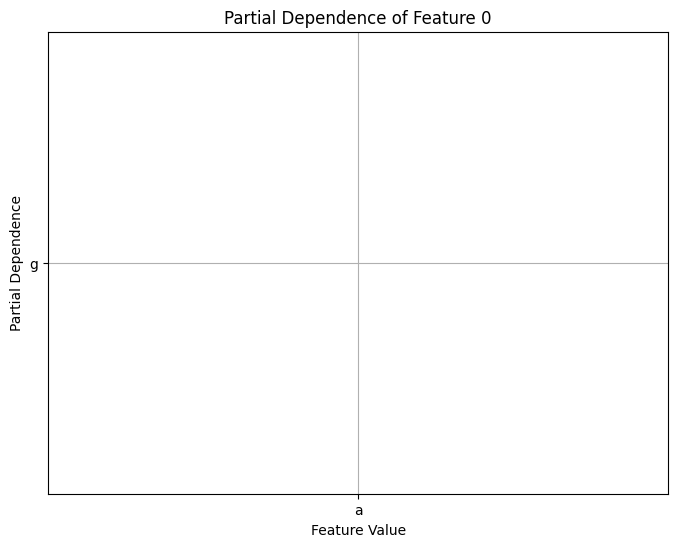

In [ ]:
from sklearn.inspection import partial_dependence
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import matplotlib.pyplot as plt

model = GradientBoostingRegressor().fit(X_train, y_train)

# Calculate Partial Dependence for the first feature
features = [(5)] # index of the feature
pdp, axes, grid = partial_dependence(model, X_train, features)

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(grid[0], pdp[0], 'b-')
plt.xlabel('Feature Value')
plt.ylabel('Partial Dependence')
plt.title('Partial Dependence of Feature 0')
plt.grid(True)
plt.show()